In [1]:
from RouteFinder import RouteFinder
import pandas as pd
from collections import namedtuple

In [2]:
'''File must be in json'''
sights_list = []
sights_df = pd.read_json('sights.json')

data = {}
Location = namedtuple('Location', ['lat', 'lng'])
data['names'] = ['Dormy Inn Akihabara']
data['names'] += [name for name in sights_df['name']]
data['locations'] = [Location(35.702540, 139.773290)]
data['locations'] += [Location(point.location[0], point.location[1]) for point in sights_df.itertuples()]
data['num_locations'] = len(data['locations'])
data['hotel_index'] = 0

#Rest of this is test stuff, find a way to transform the data
data['time_windows'] = [(480,480)] + [(480,1020) for i in range(data['num_locations']-1)]
data['visit_times'] = [0] + [90 for i in range(data['num_locations']-1)]
data['length_of_stay'] = 3
data['available_time'] = [1440 for i in range(data['length_of_stay'])]

routefinder = RouteFinder(data)
routefinder.bb = routefinder.get_bb(routefinder.data['locations'])

In [3]:
def add_time_window_constraints(routing, manager, time_evaluator_index):
    time = 'Time'
    routing.AddDimension(
        time_evaluator_index,
        15,  # allow waiting time
        1440,  # maximum time per vehicle
        False,  # don't start cumul to zero since we are giving TW to start nodes
        time)
    time_dimension = routing.GetDimensionOrDie(time)
    # Add time window constraints for each location except depot
    # Include slack in solution object
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == 0:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
        routing.AddToAssignment(time_dimension.SlackVar(index))
    # Add time window constraints for each vehicle start node
    # Include slack in solution object
    for day in range(data['length_of_stay']):
        index = routing.Start(day)
        time_dimension.CumulVar(index).SetRange(data['time_windows'][0][0],
                                                data['time_windows'][0][1])
        routing.AddToAssignment(time_dimension.SlackVar(index))
    
    # Route start and end times
    for i in range(data['length_of_stay']):
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(i)))

In [4]:
def add_capacity_constraints(routing, demand_evaluator_index):
    """Adds capacity constraint"""
    capacity = 'Capacity'
    routing.AddDimensionWithVehicleCapacity(
        demand_evaluator_index,
        0,  # capacity slack
        data['available_time'],
        True,  # start cumul to zero
        capacity)

In [5]:
routefinder.add_capacity_constraints = add_capacity_constraints
routefinder.add_time_window_constraints = add_time_window_constraints

routefinder.solve()
routefinder.print_solution()

Objective: 69933
Route for day 1:
 [Location 0: Dormy Inn Akihabara] | Time(480,480) Slack(0,0) | Time Spent Here: 0 | -> 
 [Location 10: Takeshita Street] | Time(503,503) Slack(0,0) | Travel Time From Prev: 23 | Time Spent Here: 90 | -> 
 [Location 3: Meiji Jingu] | Time(595,595) Slack(0,0) | Travel Time From Prev: 2 | Time Spent Here: 90 | -> 
 [Location 8: Ghibli Museum] | Time(724,724) Slack(0,0) | Travel Time From Prev: 39 | Time Spent Here: 90 | -> 
 [Location 13: Rikugien Gardens] | Time(868,868) Slack(0,0) | Travel Time From Prev: 54 | Time Spent Here: 90 | -> 
 [Location 9: Nezu Shrine] | Time(964,964) Slack(0,0) | Travel Time From Prev: 6 | Time Spent Here: 90 | -> 
 [Location 0: Dormy Inn Akihabara] | Time(1061,1061) | Travel Time From Prev: 7
Distance of the route: 40368m
Load of the route (Time spent at places): 450min
Travel Time of the route: 131min
Total Time of the route: 1061min
Number of sights visited: 5 places

Route for day 2:
 [Location 0: Dormy Inn Akihabara] | 

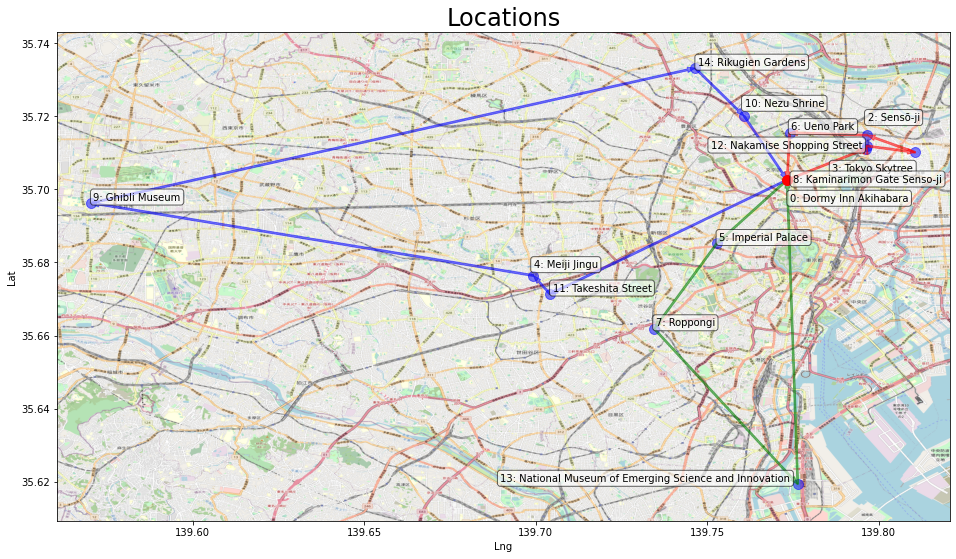

In [6]:
routefinder.visualize()